####Right now, I have respectable incomes, but  credit utilization(600),  and late days(269) and debtRatio have suspicious values. 
  - once I have clean values for all, I can engineer more features, namely monthly debt payments 
  

In [1]:
import pandas as pd
train_income = pd.read_table('train_clean.csv', sep=',', index_col='id')
test_income = pd.read_table('test_clean.csv', sep=',', index_col='id')

In [3]:
train_income.shape

(150000, 1)

In [2]:
user_cols = ['dlq' , 'credit_utilization', 'age', 'past_30', 'debtratio', 
             'income', 'credit_lines', 'past_90', 'home_lines',
             'past_60', 'dep_count']
  
training = pd.read_table('cs-training.csv', sep=',', header=False, names=user_cols)
#read file, changed index, changed names
 
test = pd.read_table('cs-test.csv', sep = ',', header=False, names=user_cols)

In [3]:
training.income = train_income.income

In [4]:
test.income = test_income.income

In [5]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)
training['dep_count'] = imp.fit_transform(training.dep_count).T
test['dep_count'] = imp.fit_transform(test.dep_count).T



In [6]:
import numpy as np

def take_log(n):
    return np.log(n)

training['lnCredit'] = training.credit_utilization.replace(to_replace=0, value = 0.1).apply(take_log)
test['lnCredit'] = test.credit_utilization.replace(to_replace=0, value = 0.1).apply(take_log)

training['lnDR'] = training.debtratio.replace(to_replace=0, value = 0.1).apply(take_log)
test['lnDR'] = test.debtratio.replace(to_replace=0, value = 0.1).apply(take_log)

training['ln30'] = training.past_30.replace(to_replace=0, value = 0.1).apply(take_log)
training['ln60'] = training.past_60.replace(to_replace=0, value = 0.1).apply(take_log)
training['ln90'] = training.past_90.replace(to_replace=0, value = 0.1).apply(take_log)

test['ln30'] = test.past_30.replace(to_replace=0, value = 0.1).apply(take_log)
test['ln60'] = test.past_60.replace(to_replace=0, value = 0.1).apply(take_log)
test['ln90'] = test.past_90.replace(to_replace=0, value = 0.1).apply(take_log)

training['lnCreditlines'] = training.credit_lines.replace(to_replace=0, value = 0.1).apply(take_log)
test['lnCreditlines'] = test.credit_lines.replace(to_replace=0, value = 0.1).apply(take_log)

training['lnincome'] = training.income.replace(to_replace=0, value = 0.1).apply(take_log)

In [7]:
test['lnincome'] = test.income.replace(to_replace=0, value = 0.1).apply(take_log)

In [9]:
import seaborn as sns
%matplotlib inline
sns.heatmap(train_ii.corr())

NameError: name 'train_ii' is not defined

In [8]:
test_sane_late_days = test[test.past_30 < 50]
test_insane_late_days = test[test.past_30 > 50 ]

train_sane_late_days = training[training.past_30 < 50]
train_insane_late_days = training[training.past_30 > 50 ]

In [9]:
train_sane_late_days['total_late_days'] = train_sane_late_days.past_30 + train_sane_late_days.past_60 + train_sane_late_days.past_90 

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
train_sane_late_days['lntotallate'] = train_sane_late_days.total_late_days.replace(to_replace=0, value = 0.1).apply(take_log)



/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
import seaborn as sns

sns.heatmap(train_sane_late_days.corr())

In [12]:
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = train_sane_late_days[['credit_utilization', 'age', 'debtratio', 'income', 'credit_lines', 'home_lines', 'dep_count', 
                        'lnCredit', 'lnDR', 'lnCreditlines', 'lnincome']]
y = train_sane_late_days.total_late_days

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

rfreg = RandomForestRegressor(n_estimators=150, max_features=8, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features=8,
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=150, n_jobs=1, oob_score=True,
           random_state=1, verbose=0)

In [13]:
#old is ypred class
y_pred = rfreg.predict(X_test)

print np.sqrt( metrics.mean_squared_error(y_test, y_pred))

1.01954209248


In [14]:
rfreg.fit(X, y)

X_impute = train_insane_late_days[['credit_utilization', 'age', 'debtratio', 'income', 'credit_lines', 'home_lines', 'dep_count', 
                        'lnCredit', 'lnDR', 'lnCreditlines', 'lnincome']]

impute_pred = rfreg.predict(X_impute)

In [15]:
train_insane_late_days['total_late_days'] = impute_pred

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
train = pd.concat([train_sane_late_days, train_insane_late_days])

In [93]:
train.isnull().sum()

age                     0
credit_lines            0
credit_utilization      0
debtratio               0
dep_count               0
dlq                     0
home_lines              0
income                  0
ln30                    0
ln60                    0
ln90                    0
lnCredit                0
lnCreditlines           0
lnDR                    0
lnincome                0
lntotallate           269
past_30                 0
past_60                 0
past_90                 0
total_late_days         0
dtype: int64

###At this point incomes, and late days are fixed, now onto fixing other features, creating features, clustering borrowers, and ultimately running some models. 

In [67]:
train.head()

,age,credit_lines,credit_utilization,debtratio,dep_count,dlq,home_lines,income,ln30,ln60,ln90,lnCredit,lnCreditlines,lnDR,lnincome,lntotallate,past_30,past_60,past_90,total_late_days
1,45,13,0.766127,0.802982,2,1,6,9120,0.693147,-2.302585,-2.302585,-0.266408,2.564949,-0.219423,9.118225,0.693147,2,0,0,2
2,40,4,0.957151,0.121876,1,0,0,2600,-2.302585,-2.302585,-2.302585,-0.043794,1.386294,-2.104749,7.863267,-2.302585,0,0,0,0
3,38,2,0.658180,0.085113,0,0,0,3042,0.000000,-2.302585,0.000000,-0.418277,0.693147,-2.463771,8.020270,0.693147,1,0,1,2
4,30,5,0.233810,0.036050,0,0,0,3300,-2.302585,-2.302585,-2.302585,-1.453247,1.609438,-3.322857,8.101678,-2.302585,0,0,0,0
5,49,7,0.907239,0.024926,0,0,1,63588,0.000000,-2.302585,-2.302585,-0.097349,1.945910,-3.691856,11.060180,0.000000,1,0,0,1


In [17]:
test_sane_late_days['total_late_days'] = test_sane_late_days.past_30 + test_sane_late_days.past_60 + test_sane_late_days.past_90 

test_sane_late_days['lntotallate'] = test_sane_late_days.total_late_days.replace(to_replace=0, value = 0.1).apply(take_log)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [18]:
X = test_sane_late_days[['credit_utilization', 'age', 'debtratio', 'income', 'credit_lines', 'home_lines', 'dep_count', 
                        'lnCredit', 'lnDR', 'lnCreditlines', 'lnincome']]
y = test_sane_late_days.total_late_days

In [19]:
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features=8,
           max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
           min_samples_split=2, n_estimators=150, n_jobs=1, oob_score=True,
           random_state=1, verbose=0)

In [20]:
X_impute = test_insane_late_days[['credit_utilization', 'age', 'debtratio', 'income', 'credit_lines', 'home_lines', 'dep_count', 
                        'lnCredit', 'lnDR', 'lnCreditlines', 'lnincome']]

impute_pred = rfreg.predict(X_impute)

In [21]:
test_insane_late_days['total_late_days'] = impute_pred
test_i = pd.concat([test_sane_late_days, test_insane_late_days])

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
train['lntotallate'] = train.total_late_days.replace(to_replace=0, value = 0.1).apply(take_log)
test_i['lntotallate'] = test_i.total_late_days.replace(to_replace=0, value = 0.1).apply(take_log)


Imputed everything in test and train

In [23]:
test_saneCU = test_i[test_i.credit_utilization < 2.5]
test_insaneCU = test_i[test_i.credit_utilization > 2.5]

train_saneCU = train[train.credit_utilization < 2.5]
train_insaneCU = train[train.credit_utilization > 2.5]

In [24]:
X = train_saneCU[['age', 'debtratio', 'income', 'dep_count', 'credit_lines', 'home_lines', 'dep_count', 
                        'lnDR', 'lnCreditlines', 'lnincome', 'lntotallate', 'total_late_days']]
y = train_saneCU.credit_utilization

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

rfreg = RandomForestRegressor(n_estimators=150, max_features=8, oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

y_pred = rfreg.predict(X_test)

print np.sqrt( metrics.mean_squared_error(y_test, y_pred))

0.285659120526


In [25]:
rfreg.fit(X, y)

X_impute = train_insaneCU[['age', 'debtratio', 'income', 'dep_count', 'credit_lines', 'home_lines', 'dep_count', 
                        'lnDR', 'lnCreditlines', 'lnincome', 'lntotallate', 'total_late_days']]

impute_pred = rfreg.predict(X_impute)

In [26]:
train_insaneCU['credit_utilization'] = impute_pred
train_ii = pd.concat([train_saneCU, train_insaneCU])

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:

X = test_saneCU[['age', 'debtratio', 'income', 'dep_count', 'credit_lines', 'home_lines', 'dep_count', 
                        'lnDR', 'lnCreditlines', 'lnincome', 'lntotallate', 'total_late_days']]
y = test_saneCU.credit_utilization

rfreg.fit(X, y)

X_impute = test_insaneCU[['age', 'debtratio', 'income', 'dep_count', 'credit_lines', 'home_lines', 'dep_count', 
                        'lnDR', 'lnCreditlines', 'lnincome', 'lntotallate', 'total_late_days']]

impute_pred = rfreg.predict(X_impute)

test_insaneCU['credit_utilization'] = impute_pred
test_ii = pd.concat([test_saneCU, test_insaneCU])

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
train_ii['lnCreditlines'] = train_ii.credit_lines.replace(to_replace=0, value = 0.1).apply(take_log)
test_ii['lnCreditlines'] = test_ii.credit_lines.replace(to_replace=0, value = 0.1).apply(take_log)

In [29]:
train_ii['income'] = train_ii.income.replace(to_replace=0, value = 1)
test_ii['income'] = test_ii.income.replace(to_replace=0, value = 1)

In [162]:
test_ii.income.describe()

count     101503.000000
mean        5561.077229
std        32812.266653
min            0.003333
25%         1816.500000
50%         4408.000000
75%         7392.000000
max      7727000.000000
Name: income, dtype: float64

In [30]:

train_ii['expenses'] = train_ii.income * train_ii.debtratio
test_ii['expenses'] = test_ii.income * test_ii.debtratio

In [31]:
train_ii['lnExpenses'] = train_ii.expenses.replace(to_replace=0, value = 0.1).apply(take_log)
test_ii['lnExpenses'] = test_ii.expenses.replace(to_replace=0, value = 0.1).apply(take_log)

In [32]:
train_ii['expenses_2'] = train_ii.expenses ** 2
test_ii['expenses_2'] = test_ii.expenses ** 2

In [33]:
train_ii['credit_limit'] = (train_ii.expenses.replace(to_replace=0, value = 1)
                           ) / (train_ii.credit_utilization.replace(to_replace=0, value = 1))

test_ii['credit_limit'] = (test_ii.expenses.replace(to_replace=0, value = 1)
                          ) / (test_ii.credit_utilization.replace(to_replace=0, value = 1))

In [34]:
train_ii['lnlimit'] = train_ii.credit_limit.replace(to_replace=0, value = 0.1).apply(take_log)
test_ii['lnlimit'] = test_ii.credit_limit.replace(to_replace=0, value = 0.1).apply(take_log)

In [35]:
train_ii['free_credit'] = (train_ii.credit_limit - train_ii.expenses)
test_ii['free_credit'] = (train_ii.credit_limit - test_ii.expenses)

In [36]:
train_ii['lim_2'] = train_ii.credit_limit ** 2
test_ii['lim_2'] = test_ii.credit_limit ** 2

In [37]:
train_ii['lnfree'] = train_ii.free_credit.replace(to_replace= [train_ii.free_credit <0.01], value = 0.1).apply(take_log)
test_ii['lnfree'] = test_ii.free_credit.replace(to_replace= [test_ii.free_credit <0.01], value = 0.1).apply(take_log)

In [38]:
train_ii['savings'] = train_ii.income - train_ii.expenses
test_ii['savings'] = test_ii.income - test_ii.expenses

In [211]:
train_ii[(train_ii.savings < -1)]

,age,credit_lines,credit_utilization,debtratio,dep_count,dlq,home_lines,income,ln30,ln60,...,expenses,lnExpenses,expenses_2,credit_limit,lnlimit,free_credit,lim_2,lnfree,total_lines,savings
count,275.000000,275.000000,275.000000,275.000000,275.000000,275,275.000000,275.000000,275.000000,275.000000,...,275.000000,275.000000,2.750000e+02,275.000000,275.000000,275.000000,2.750000e+02,224.000000,275.000000,275.000000
mean,46.909091,6.509091,0.848069,1829.779069,0.556364,1,1.170909,1153.501042,0.014732,-0.701361,...,464563.971319,11.073545,2.935941e+12,1524554.892312,11.411819,1059990.920993,6.863375e+13,4.112318,7.680000,-463410.470276
std,13.913015,6.395918,0.431164,3846.069186,1.107170,0,2.568029,2037.491893,2.064053,2.019286,...,1652286.002782,1.657609,2.608155e+13,8157909.742253,1.975617,7222167.003631,6.777258e+14,8.341382,8.289436,1652427.147148
min,22.000000,0.000000,0.000000,2.485255,0.000000,1,0.000000,1.000000,-2.302585,-2.302585,...,10425.173333,9.251979,1.086842e+08,7399.198995,8.909127,-414136.300470,5.474815e+07,-6.855739,0.000000,-20230781.473322
25%,35.000000,1.000000,0.613090,30.306443,0.000000,1,0.000000,50.158333,-2.302585,-2.302585,...,20140.713333,9.910484,4.056598e+08,22777.089197,10.033499,0.001301,5.188082e+08,-5.417982,1.000000,-99944.155000
50%,47.000000,5.000000,0.992782,185.000000,0.000000,1,0.000000,375.080000,0.000000,-2.302585,...,36262.600000,10.498542,1.314976e+09,48747.470987,10.794409,0.010815,2.376316e+09,8.225068,5.000000,-33952.000000
75%,55.000000,10.000000,1.000000,2063.000000,1.000000,1,1.000000,1469.428333,1.386294,0.000000,...,101426.765000,11.526944,1.029044e+10,153280.428600,11.940017,27989.297161,2.349523e+10,10.949138,12.000000,-18638.235000
max,94.000000,29.000000,2.494658,32843.000000,6.000000,1,17.000000,13500.000000,4.584967,4.584967,...,20231397.476656,16.822746,4.093094e+14,89603033.703338,18.310900,86860233.604690,8.028704e+15,18.279811,46.000000,-10150.826667


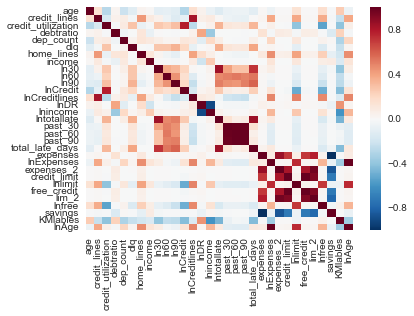

In [55]:
%matplotlib inline
sns.heatmap(train_new.corr())

In [226]:
train_ii.isnull().sum()

age                      0
credit_lines             0
credit_utilization       0
debtratio                0
dep_count                0
dlq                      0
home_lines               0
income                   0
ln30                     0
ln60                     0
ln90                     0
lnCredit                 0
lnCreditlines            0
lnDR                     0
lnincome                 0
lntotallate              0
past_30                  0
past_60                  0
past_90                  0
total_late_days          0
expenses                 0
lnExpenses               0
expenses_2               0
credit_limit             0
lnlimit                  0
free_credit              0
lim_2                    0
lnfree                3019
total_lines              0
savings                  0
dtype: int64

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = train_ii[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, random_state=1)

In [41]:
km.fit(X_scaled)



KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=1, tol=0.0001,
    verbose=0)

In [42]:
train_ii['KMlables'] = km.labels_

In [43]:
X = test_ii[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
km.fit(X_scaled)
test_ii['KMlables'] = km.labels_


In [44]:
X = train_ii[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]
y = train_ii.dlq
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

####Reloading new test/train to CSV to preserve sanciity

train_ii.to_csv('train_new.csv')
test_ii.to_csv('test_new.csv')

In [1]:
import pandas as pd
train_new = pd.read_table('train_new.csv', sep=',', index_col= 'Unnamed: 0')
test_new = pd.read_table('test_new.csv', sep=',', index_col= 'Unnamed: 0')

In [2]:
train_new.head()

,age,credit_lines,credit_utilization,debtratio,dep_count,dlq,home_lines,income,ln30,ln60,...,expenses,lnExpenses,expenses_2,credit_limit,lnlimit,free_credit,lim_2,lnfree,savings,KMlables
1,45,13,0.766127,0.802982,2,1,6,9120,0.693147,-2.302585,...,7323.197016,8.898802,53629214.542200,9558.729498,9.165210,2235.532481,91369309.611700,7.712235,1796.802984,0
2,40,4,0.957151,0.121876,1,0,0,2600,-2.302585,-2.302585,...,316.878123,5.758517,100411.744583,331.063872,5.802311,14.185750,109603.287455,2.652238,2283.121877,2
3,38,2,0.658180,0.085113,0,0,0,3042,0.000000,-2.302585,...,258.914887,5.556499,67036.918581,393.379975,5.974776,134.465088,154747.804410,4.901305,2783.085113,0
4,30,5,0.233810,0.036050,0,0,0,3300,-2.302585,-2.302585,...,118.963951,4.778821,14152.421542,508.806572,6.232068,389.842621,258884.127594,5.965743,3181.036049,2
5,49,7,0.907239,0.024926,0,0,1,63588,0.000000,-2.302585,...,1584.975094,7.368324,2512146.047520,1747.030711,7.465673,162.055617,3052116.303760,5.087940,62003.024906,0


In [4]:
import numpy as np

def take_log(n):
    return np.log(n)

train_new['lnAge'] = train_new.expenses.replace(to_replace=0, value = 0.1).apply(take_log)
test_new['lnAge'] = test_new.expenses.replace(to_replace=0, value = 0.1).apply(take_log)

###Stochastic  Gradient Dissent


In [15]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="log", penalty="l2")

In [16]:
from sklearn.cross_validation import train_test_split

X = train_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]
y = train_new.dlq
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [17]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred)

0.934933333333


In [18]:
clf.fit(X, y)

X_test = test_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]

SGD_pred = clf.predict_proba(X_test)

###ADABoost

In [19]:
from sklearn.ensemble import AdaBoostClassifier
X = train_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]
y = train_new.dlq
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

adb = AdaBoostClassifier()

adb.fit(X_train, y_train)

y_pred = adb.predict(X_test)

from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred)

0.937413333333


In [20]:
adb.fit(X, y)

X_test = test_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]

ADB_pred = adb.predict_proba(X_test)

###Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

rfclass = RandomForestClassifier(n_estimators=150, max_features=8, oob_score=True, random_state=1)
X = train_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]
y = train_new.dlq
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

rfclass.fit(X_train, y_train)

y_pred = rfclass.predict(X_test)

from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred)


0.936106666667


In [25]:
rfclass.fit(X, y)

X_test = test_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]

RF_pred = rfclass.predict_proba(X_test)

###Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e9)
X = train_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]
y = train_new.dlq
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred)


0.934933333333


In [28]:
logreg.fit(X, y)

X_test = test_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]

LR_pred = logreg.predict_proba(X_test)

###GBM

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

X = train_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]
y = train_new.dlq
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)


0.938346666667


In [30]:
logreg.fit(X, y)

X_test = test_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]

GBC_pred = gbc.predict_proba(X_test)

##Ridge

In [44]:
from sklearn.svm import LinearSVC

In [ ]:
lsvc = LinearSVC()
X = train_new[['age', 'credit_lines', 'credit_utilization', 'debtratio', 'dep_count', 'home_lines', 
             'income','lnCredit', 'lnCreditlines', 'lnDR', 'lnincome', 'lntotallate', 'total_late_days',
             'lnlimit', 'KMlables', 'free_credit',  'lim_2', 'savings']]
y = train_new.dlq
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

rid.fit(X_train, y_train)

y_pred = rid.predict(X_test)

print metrics.accuracy_score(y_test, y_pred)


In [40]:
y_prob_combined = (GBC_pred[:,1] + LR_pred[:,1] + RF_pred[:,1] + ADB_pred[:,1] + SGD_pred[:,1])/5

In [42]:
sub = pd.DataFrame({'id':test_new.index, 'Probability':y_prob_combined}).set_index('id')
sub.to_csv('sub_ensemble_five.csv')